## Домашнее задание №7
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Авторы: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), Горохов Олег

Ваша основная задача: научиться генерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# Не меняйте блок кода ниже! Здесь указаны все необходимые import-ы
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [ ]:
# Не меняйте блок кода ниже!
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt -O ./onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text]) # Убираем лишние символы табуляций, приводим все буквы к нижнему регистру
# __________end of block__________

--2023-12-02 20:58:13--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘./onegin.txt’

./onegin.txt        100%[===================>] 256.37K  --.-KB/s    in 0.005s  

2023-12-02 20:58:14 (54.1 MB/s) - ‘./onegin.txt’ saved [262521/262521]



Выведем несколько первых символов входного текста. Видим, что символы табуляций удалены, буквы приведены к нижнему регистру. Символы \n мы оставляем - чтобы научить сеть генерировать символ \n, когда нужно перейти на новую строку.

In [ ]:
text[:36]

'\ni\n\n«мой дядя самых честных правил,\n'

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим технический токен `<sos>`.

In [ ]:
# Не меняйте блок кода ниже!
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>'] # Строим множество всех токенов-символов и добавляем к нему служебный токен <sos>
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)} # Строим словарь с ключами-токенами и значениями-индексами в списке токенов
idx_to_token = {idx: x for idx, x in enumerate(tokens)} # Строим обратный словарь (чтобы по индексу можно было получить токен)

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятия №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# Не меняйте код ниже
# __________start of block__________
batch_size = 256 # Размер батча. Батч - это набор последовательностей символов.
seq_length = 100 # Максимальная длина одной последовательности символов в батче
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>'] # Добавляем в начало каждой строки технический символ - для определения начального состояния сети

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1) # Случайным образом выбираем индекс начального символа в батче
    # Строим непрерывный батч.
    # Для этого выбираем в исходном тексте подпоследовательность, которая начинается с индекса start_index и имеет размер batch_size*seq_length.
    # Затем мы делим эту подпоследовательность на batch_size последовательностей размера seq_length. Это и будет батч, матрица размера batch_size*seq_length.
    # В каждой строке матрицы будут указаны индексы
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83, 50, 61, ..., 48, 45, 57],
       [83, 53,  0, ..., 61, 76, 48],
       [83, 45, 75, ..., 57, 45, 63],
       ...,
       [83, 57, 68, ..., 49, 64, 69],
       [83, 53,  1, ..., 53, 58, 76],
       [83,  1, 60, ..., 53, 62, 73]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, hidden_size=64, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, hidden=None):
        x = self.emb(x)
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

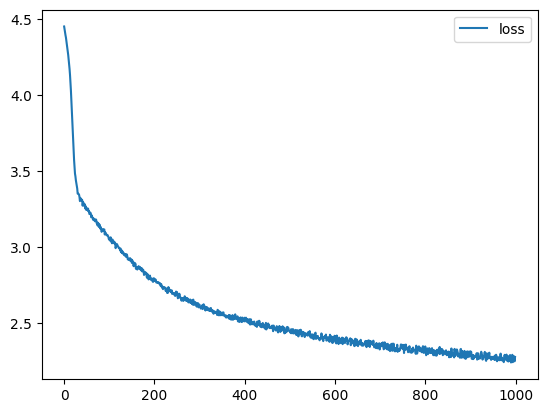

In [ ]:
# Создаем модель и переносим ее на выбранное устройство
char_rnn = CharRNN().to(device)

# Задаем функцию потерь и оптимизатор
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn.parameters())

# Количество эпох и интервал для вывода графика
num_epochs = 1000
plot_interval = 50

history = []

for epoch in range(num_epochs):
    # Генерируем батчи
    for batch in generate_chunk():
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Преобразуем данные и переносим их на выбранное устройство
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        # Прогоняем данные через модель и вычисляем функцию потерь
        outputs, _ = char_rnn(inputs)
        loss = loss_function(outputs.contiguous().view(-1, num_tokens), targets.contiguous().view(-1))

        # Обновляем параметры модели
        loss.backward()
        optimizer.step()

        # Записываем значение функции потерь
        history.append(loss.item())

    # Выводим график функции потерь
    if (epoch + 1) % plot_interval == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    char_rnn.eval()
    with torch.no_grad():
        if seed_phrase is not None:
            x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
        else:
            x_sequence = [token_to_idx['<sos>']]

        x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
        hidden = None

        for _ in range(max_length - len(seed_phrase)):
            outputs, hidden = char_rnn(x_sequence[:, -1].unsqueeze(1), hidden)
            probabilities = F.softmax(outputs / temperature, dim=-1)
            next_token = torch.multinomial(probabilities.squeeze(), num_samples=1)
            x_sequence = torch.cat([x_sequence, next_token.unsqueeze(1)], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
generated_phrases = [
    generate_sample(
        char_rnn,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

for idx, phrase in enumerate(generated_phrases):
    print(f"Phrase {idx + 1}:")
    print(phrase)
    print("\n")

Phrase 1:
 мой дядя самых честных правильната мном
дскрянуень» «сё
че ней мы чога
замнает,
сто плехонот:
прерной перешывамарьно тет обесотит, содно тривела
ъытовор пол
кахояньло догою забевьли,
за нлюбисть не цари.



xl
томенняя с мискайстью: ловоек
как в онегре у ня в ен поласанкив либил смодошмых на пруд ворваня нишезденем суджеет слувельной, доло от; за свено, я стале сушитый!
еать,
и пушу лжянье шуфи члогиннахо скородя  с блашены фуды,
рестотежат ни в я сненье ды и им рада логокой:
в скае;
тетил осто


Phrase 2:
 мой дядя самых честных правилю ей ланкали им кодет и тюшнам лю релятя; мничаний



li

попрысть не глязных никоволок керезкаеньа ведит лечим сиды, м пупарьй
ленемно михомся прачетит мепнает мою такте,
то доли,
ой раздцей буждролочать свотродой;
иныры...



lxxv

)
вез:
предь он безам оз гестолн он думае гживовша
и готой чути,
анный делой,:
помней



xxi

иглилу, зегивила обимитбали уш суг ном столатьесь и хлобое и не правы струзилерыо мне презали;
вы в велосам обта риселж

### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = [
    generate_sample(
        char_rnn,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.0
    ).replace('<sos>', '')
    for _ in range(10)
]

for idx, phrase in enumerate(generated_phrases):
    print(f"Phrase {idx + 1}:")
    print(phrase)
    print("\n")

Phrase 1:
 мой дядя самых честных правильскук, ливать. —
« оными,
ин! надою
пввосси, приновскный
и све быми ликоr, причье влесно позралений поя стовесте
ского сти знетня!
ватный всту молодогнорость оспелик,
ий жта помоновбовда
начуд;
падори,
и кашчою димась очавый мбевный,
гедрую слешны,
годо не пыл
драгили
доленье,
пове, не свей градать – моярок милохить не можь о ды:
растыю
к браги
ктад мисто в кенодень» в:
гдрешном, ч туктя тить евнык еслой,
на нрасежным,
а-когда потных ридушнь влед ее жечни: не выэт п


Phrase 2:
 мой дядя самых честных правилыхристит.
с даралима на мивосных
алого,
то кудров жемну? чспуравье не позда хруз?
в и бежер доватный очелье,
пра враня… стали, уж у когос;-и тилай!
престаенны, цду йкиму на де, когой
онегоной лью;



ix

гоядил;
она хружнас
кажел
и потрив



xxvi

зебатных ка гиной;



xx

разшят думали прудьк ом за что стух сескогил лучта судале
рапитерая, долюный
оних деро.


я лесьит, мей дар рошь наморь;
не хре сную похо таки сопуднно былый мепи;
о лейь ра

In [ ]:
# do not change the code in the block below
# __________start of block__________

if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!